# Model Training

## 1. Import Libraries

We import **pandas** and **numpy** for data handling, and **scikit‑learn** modules for preprocessing and splitting.

In [185]:
import pandas as pd
import numpy as np

In [186]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

---

## 2. Load the Dataset

Load the full ASSISTments CSV into a DataFrame.  

In [187]:
df = pd.read_csv('assistments_2009_2010.csv')

---

## 3. Initial Exploration

- **Shape** tells us total rows & columns.  
- **head()** previews the first 5 rows.  
- **info()** shows dtypes & non‑null counts.  
- **isnull().sum()** reveals missing values per column.

In [188]:
df.sample(10)

,order_id,assignment_id,user_id,assistment_id,problem_id,original,correct,attempt_count,ms_first_response_time,tutor_mode,answer_type,sequence_id,student_class_id,position,problem_set_type,base_sequence_id,list_skill_ids,list_skills,teacher_id,school_id
913376,38172252,291481,96235,38380,61678,0,0.0,5,20625.0,tutor,algebra,6022.0,14415.0,45.0,MasterySection,6022.0,NaN,NaN,69274.0,5794.0
132722,22650238,264625,64549,24728,28910,1,0.0,2,95894.0,tutor,choose_1,5005.0,12474.0,1.0,RandomChildOrderSection,5005.0,4,Histogram as Table or Graph,22551.0,76.0
515705,29655025,272174,86441,12320,12320,1,0.0,1,46091.0,tutor,fill_in_1,2427.0,12953.0,2.0,RandomChildOrderSection,2427.0,92,Pattern Finding,53103.0,NaN
876415,35974363,284009,81545,29455,41528,1,1.0,1,5718.0,tutor,algebra,9992.0,12626.0,1.0,LinearSection,9992.0,81,Unit Rate,29563.0,73.0
238443,24736282,266957,79538,28958,40599,1,1.0,1,20373.0,test,choose_1,5527.0,12445.0,35.0,LinearSection,5527.0,NaN,NaN,14630.0,2770.0
46670,21322164,263353,34037,24073,24073,1,1.0,1,7333.0,tutor,choose_1,4893.0,12477.0,1.0,RandomChildOrderSection,4893.0,63,Estimation,19047.0,2770.0
287860,25574338,267289,70991,45680,83312,1,1.0,1,45326.0,pre,choose_1,8701.0,12693.0,1.0,LinearSection,8701.0,NaN,NaN,50469.0,73.0
807740,34692859,272587,78895,37802,60087,1,0.0,1,3266.0,tutor,fill_in_1,6011.0,12438.0,29.0,MasterySection,6011.0,76,Finding Fractions and Ratio,23907.0,76.0
390709,27613898,270305,78523,46761,85089,1,0.0,1,105610.0,test,algebra,9324.0,12262.0,1.0,RandomChildOrderSection,9324.0,70,Percent Of,46174.0,5056.0
226554,24563225,263493,83831,22666,22667,0,0.0,3,64615.0,tutor,choose_1,5330.0,12321.0,1.0,RandomChildOrderSection,5330.0,NaN,NaN,11161.0,1357.0


In [189]:
print("Shape:", df.shape)
display(df.isnull().sum())

Shape: (1011079, 20)


,0
order_id,0
assignment_id,0
user_id,0
assistment_id,0
problem_id,0
original,0
correct,0
attempt_count,0
ms_first_response_time,125
tutor_mode,0


---

# Data Pre-Processing

In [190]:
# Map answer types to broader categories
answer_type_mapping = {
    'algebra': 'Problem-Solving',
    'choose_1': 'Knowledge-Based',
    'fill_in_1': 'Knowledge-Based',
    'choose_n': 'Strategic Reasoning',
    'open_response': 'Problem-Solving',
    'rank': 'Strategic Reasoning',
    'external': 'Knowledge-Based'  # assuming "external" is simple lookup questions
}

# Apply the mapping
df['answer_type'] = df['answer_type'].map(answer_type_mapping)
df['answer_type'].value_counts()

,count
answer_type,
Problem-Solving,580943
Knowledge-Based,423038
Strategic Reasoning,7098


In [191]:
# Normalizing the correct column
df['correct'] = df['correct'].apply(lambda x: 1 if x > 0.5 else 0)

In [192]:
# Filter the data to only include test or post mode and original equals 1
df_filtered = df.loc[(df['tutor_mode'] == 'test') | (df['tutor_mode'] == 'post')]
df_filtered = df_filtered.loc[df['original'] == 1]

In [193]:
# Drop the unneeded columns based on the list you provided
df_filtered = df_filtered.drop(columns=['order_id', 'assignment_id', 'assistment_id',
                                         'problem_id', 'ms_first_response_time',
                                        'sequence_id', 'student_class_id', 'original',
                                         'position', 'problem_set_type', 'base_sequence_id',
                                         'list_skill_ids', 'list_skills', 'teacher_id', 'school_id'])

In [194]:
# Aggregate the data by user_id and answer_type, summing the correct answers for each category
aggregated_df = df_filtered.groupby(['user_id', 'answer_type']).agg(
    correct_sum=('correct', 'sum')  # Sum of correct answers
).reset_index()

In [195]:
# Count the number of rows (questions answered) per user_id and answer_type
total_questions_per_category = df_filtered.groupby(['user_id', 'answer_type']).size().reset_index(name='total_questions')

# Merge the total questions into the aggregated data
aggregated_df = pd.merge(aggregated_df, total_questions_per_category, on=['user_id', 'answer_type'])

In [196]:
aggregated_df.sample(180).to_csv('sample.csv', index=False)

In [197]:
# Calculate the percentage of correct answers for each student and category
aggregated_df['correct_percentage'] = (aggregated_df['correct_sum'] / aggregated_df['total_questions']) * 100

In [198]:
aggregated_df

,user_id,answer_type,correct_sum,total_questions,correct_percentage
0,33121,Problem-Solving,20,20,100.000000
1,34037,Knowledge-Based,3,7,42.857143
2,34037,Problem-Solving,0,1,0.000000
3,53167,Knowledge-Based,32,39,82.051282
4,53167,Problem-Solving,17,29,58.620690
...,...,...,...,...,...
4046,96298,Knowledge-Based,23,30,76.666667
4047,96298,Problem-Solving,5,17,29.411765
4048,96298,Strategic Reasoning,0,1,0.000000
4049,96299,Knowledge-Based,15,18,83.333333


---

In [199]:
# Drop unnecessary columns
final_data = aggregated_df.drop(columns=['correct_sum', 'total_questions'])

In [200]:
final_data

,user_id,answer_type,correct_percentage
0,33121,Problem-Solving,100.000000
1,34037,Knowledge-Based,42.857143
2,34037,Problem-Solving,0.000000
3,53167,Knowledge-Based,82.051282
4,53167,Problem-Solving,58.620690
...,...,...,...
4046,96298,Knowledge-Based,76.666667
4047,96298,Problem-Solving,29.411765
4048,96298,Strategic Reasoning,0.000000
4049,96299,Knowledge-Based,83.333333


In [201]:
final_data_encoded = pd.get_dummies(final_data)

---

# Data Labeling

In [202]:
from sklearn.cluster import KMeans

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
final_data_encoded['cluster'] = kmeans.fit_predict(final_data_encoded[['correct_percentage']])

# Check the new clustering results
final_data_encoded.head()

,user_id,correct_percentage,answer_type_Knowledge-Based,answer_type_Problem-Solving,answer_type_Strategic Reasoning,cluster
0,33121,100.000000,False,True,False,0
1,34037,42.857143,True,False,False,1
2,34037,0.000000,False,True,False,2
3,53167,82.051282,True,False,False,0
4,53167,58.620690,False,True,False,1


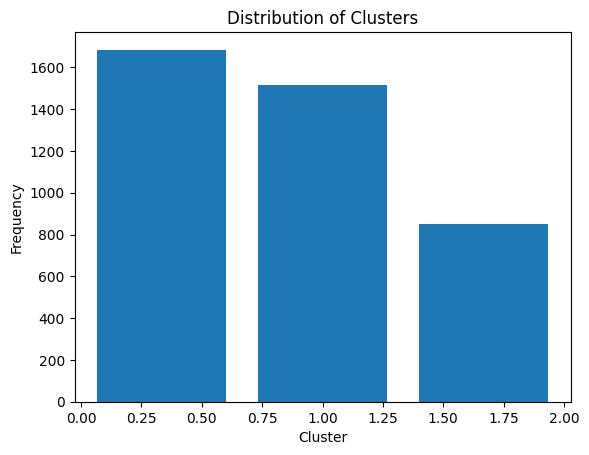

In [203]:
import matplotlib.pyplot as plt

plt.hist(final_data_encoded['cluster'], bins=3, rwidth=0.8) #added rwidth
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Clusters')
plt.show()

---

# Model Training

In [204]:
# Now reorganize it
def get_answer_type(row):
    if row['answer_type_Knowledge-Based']:
        return 'Knowledge-Based'
    elif row['answer_type_Problem-Solving']:
        return 'Problem-Solving'
    elif row['answer_type_Strategic Reasoning']:
        return 'Strategic Reasoning'
    else:
        return 'Unknown'

# Apply to create a new column
final_data_encoded['answer_type'] = final_data_encoded.apply(get_answer_type, axis=1)

# Drop the old encoded columns
final_data = final_data_encoded.drop(columns=[
    'answer_type_Knowledge-Based',
    'answer_type_Problem-Solving',
    'answer_type_Strategic Reasoning'
])

In [205]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, classification_report

In [206]:
X = final_data.drop(columns=['user_id', 'cluster'])
y = final_data['cluster']

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [208]:
X_train

,correct_percentage,answer_type
1022,74.035088,Problem-Solving
1614,53.846154,Strategic Reasoning
3414,33.333333,Problem-Solving
3484,0.000000,Knowledge-Based
1912,77.611940,Knowledge-Based
...,...,...
1130,0.000000,Strategic Reasoning
1294,40.000000,Strategic Reasoning
860,57.142857,Knowledge-Based
3507,25.000000,Problem-Solving


In [209]:
model_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
model_pipe.fit(X_train, y_train)

Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore')),
                ('classifier', RandomForestClassifier(random_state=42))])

In [210]:
train_y_pred = model_pipe.predict(X_train)
test_y_pred = model_pipe.predict(X_test)

In [211]:
print("Train Recall:", recall_score(y_train, train_y_pred, average='weighted'))
print("Test Recall:", recall_score(y_test, test_y_pred, average='weighted'))

Train Recall: 1.0
Test Recall: 0.935881627620222


In [212]:
print("Train F1 Score:", f1_score(y_train, train_y_pred, average='weighted'))
print("Test F1 Score:", f1_score(y_test, test_y_pred, average='weighted'))

Train F1 Score: 1.0
Test F1 Score: 0.9361180485047029


In [213]:
print(classification_report(y_train, train_y_pred))
print(classification_report(y_test, test_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1346
           1       1.00      1.00      1.00      1216
           2       1.00      1.00      1.00       678

    accuracy                           1.00      3240
   macro avg       1.00      1.00      1.00      3240
weighted avg       1.00      1.00      1.00      3240

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       338
           1       0.89      0.97      0.93       299
           2       1.00      0.89      0.94       174

    accuracy                           0.94       811
   macro avg       0.95      0.93      0.94       811
weighted avg       0.94      0.94      0.94       811



---

# Model Saving

In [214]:
import joblib

joblib.dump(model_pipe, 'model_pipe.joblib')

['model_pipe.joblib']